In [3]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'README', 'imdbEr.txt', 'test']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_pos.txt',
 'pos',
 'unsup',
 'neg',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_unsup.txt']

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
print('done')

done


In [7]:
batch_size = 1024
seed = 12345
train_ds = tf.keras.utils.text_dataset_from_directory(
                            'aclImdb/train', batch_size=batch_size, 
                            validation_split=0.3,
                            subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
                            'aclImdb/train', batch_size=batch_size, 
                            validation_split=0.3,
                            subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 17500 files for training.
Found 25000 files belonging to 2 classes.
Using 7500 files for validation.


In [8]:
vocab_size   = 20000
sequence_len = 200

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

vectorization = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_len,
)

vectorization.adapt(train_ds.map(lambda text, label: text))

In [9]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorization(text), label

train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
print(train_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [10]:
for text_batch, label_batch in train_ds:
    print(label_batch[0].numpy())
    print(text_batch.numpy()[0])
    break

0
[   11   315     2   955     5     1    35  2315  1502    26  1032     4
   724   635     5 18028    10   400  3748  1169 15466     5  1594  4641
    13   967    11    59    38     6  1272  1284     3    77    36    24
   887     8     1     1     5  4042     2     1  3987     3  4997     3
    25   289     2    17  7400     4  4990  1013    15   117   130  6510
    23   205     8     2    17    25 11775    15  6181     3    74   137
    20    14   206    14   117 16521    11   235    35    10  6005     5
  4042   538    11   235     4     1  1284    11   235   781     6  1269
    23    18     1  6005     5     1     7     8  4042    21     8     1
    14    23  1039     8   123   955  4042     3     1    24   105   267
     3  4649  3105   651    33  8093    15    33     1     7   216    38
   651    33   312    15    33  2629  1184     1     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

In [12]:
from tensorflow.keras import layers
from tensorflow import keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [13]:
# Two seperate embedding layers, one for tokens, one for token index (positions)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
embed_dim = 128  # Embedding size for each token
num_heads = 6    # Number of attention heads
ff_dim = 128     # Hidden layer size in feed forward network inside transformer

embedding_layer = TokenAndPositionEmbedding(sequence_len, vocab_size, embed_dim)
transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)

inputs = layers.Input(shape=(sequence_len,))
x = embedding_layer(inputs)
x = transformer_block1(x, training = True)
x = transformer_block2(x, training = True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 128)       │     2,585,600 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 128)       │       429,184 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 128)       │       429,184 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,448,162 (13.15 MB)

 Trainable params: 3,448,162 (13.15 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, batch_size=32, epochs=15, validation_data=val_ds)

Epoch 1/15


I0000 00:00:1722853432.018897     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722853432.045862     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5061 - loss: 0.8334   

W0000 00:00:1722853453.248045     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5062 - loss: 0.8292 - val_accuracy: 0.5229 - val_loss: 0.6892
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - accuracy: 0.5412 - loss: 0.6885 - val_accuracy: 0.5364 - val_loss: 0.6747
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - accuracy: 0.6439 - loss: 0.6317 - val_accuracy: 0.8128 - val_loss: 0.4229
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.8219 - loss: 0.4141 - val_accuracy: 0.8573 - val_loss: 0.3510
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.9239 - loss: 0.2066 - val_accuracy: 0.8636 - val_loss: 0.3398
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.9463 - loss: 0.1459 - val_accuracy: 0.8689 - val_loss: 0.3540
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.9800 - loss: 0.0664 - val_accuracy: 0.8383 - val_loss: 0.7855
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.9809 - loss: 0.0579 - val_accuracy: 0.8320 -

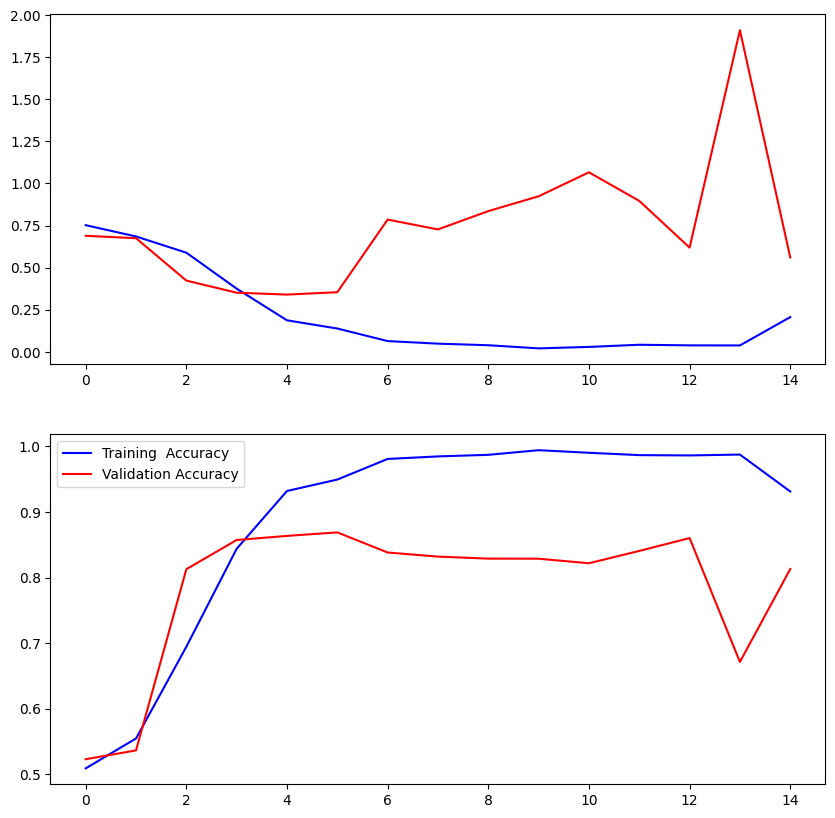

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()